In [164]:
pwd

'/Users/ravnandy/Documents'

In [165]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score

%matplotlib inline

In [166]:
# Data gathering
# Import data into dataframes
calendar = pd.read_csv("./seattle/calendar.csv")
listings = pd.read_csv("./seattle/listings.csv")
reviews = pd.read_csv("./seattle/reviews.csv")

In [167]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [168]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [169]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [170]:
'some random data exploration'

listings.id.nunique()

3818

In [171]:
#clean calendar data

df_calendar=calendar.copy()
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [172]:
 data_calendar = df_calendar[df_calendar['available'] == 'f'].groupby('date').count()['listing_id'].reset_index()

In [173]:
data_calendar.head()

,date,listing_id
0,2016-01-04,2083
1,2016-01-05,1951
2,2016-01-06,1992
3,2016-01-07,2042
4,2016-01-08,2036


In [174]:
# Then divide that number by the total number of houses in the dataset
data_calendar['listing_id'] = data_calendar['listing_id'] / df_calendar.listing_id.nunique()
# Rename the columns
data_calendar.columns = ['date', 'occupancy_rate']
# Cast the datatype of the date column so that we can use plot_date.
data_calendar['date'] = pd.to_datetime(data_calendar['date'])

In [175]:
#clean review_data
df_reviews = reviews.copy()
# Group by on date and count how many reviews were made on that day
data_reviews = df_reviews.groupby('date').count()['id'].reset_index()
# Reset the column names
data_reviews.columns = ['date', 'num_reviews']
# Cast the datatype of the date column so that we can use plot_date.
data_reviews['date'] = pd.to_datetime(data_reviews['date'])

In [176]:
#data_calendar['listing_id'].nunique()

In [177]:
data_calendar.head()

,date,occupancy_rate
0,2016-01-04,0.545574
1,2016-01-05,0.511001
2,2016-01-06,0.521739
3,2016-01-07,0.534835
4,2016-01-08,0.533263


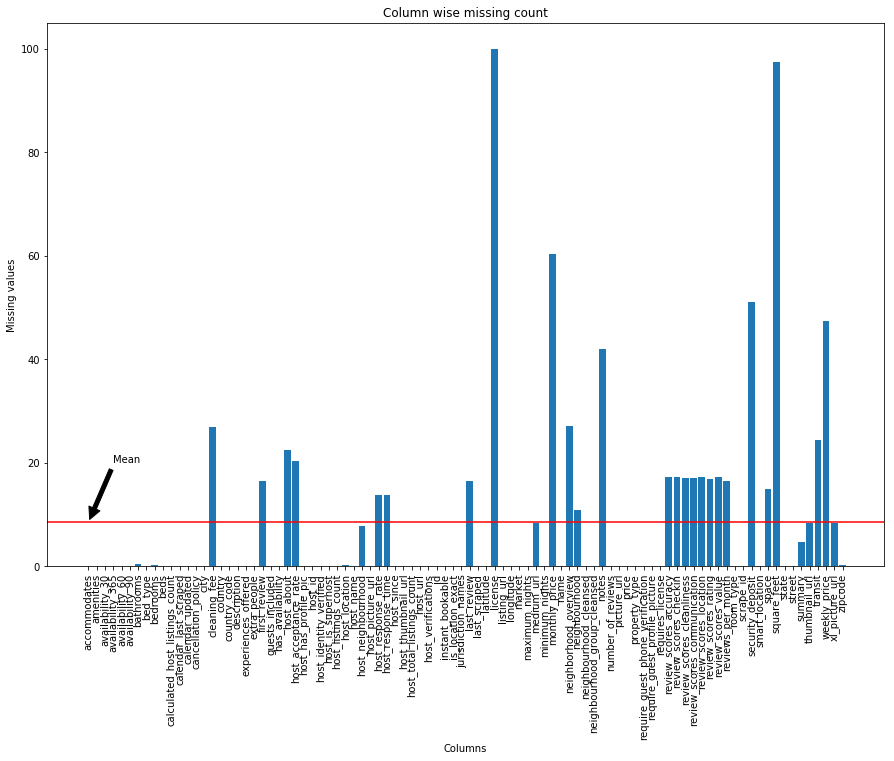

In [178]:
#find percentage of missing data in listings

listings.isnull().sum()

missing_values_percent=[(listings[series].isnull().sum()/listings[series].shape[0])*100 for series in list(listings) ]
columns= list(listings)
mean=np.mean(missing_values_percent)
fig,ax=plt.pyplot.subplots(figsize=(15,10))
plt.pyplot.title("Column wise missing count")
plt.pyplot.xlabel("Columns")
plt.pyplot.ylabel("Missing values")

plt.pyplot.axhline(y=mean, c='r', label='"Mean"')

ax.annotate('Mean', xy=(0, mean), xytext=(3, 20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.pyplot.bar(columns, missing_values_percent)
plt.pyplot.xticks(rotation=90);

(array([67., 14.,  5.,  0.,  2.,  1.,  1.,  0.,  0.,  2.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

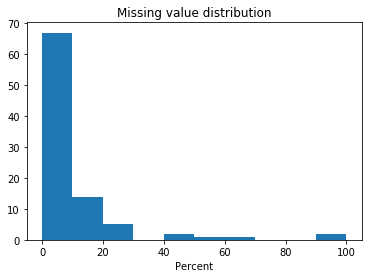

In [179]:
#Get missing value  distribution

plt.pyplot.title("Missing value distribution")
plt.pyplot.xlabel("Percent")
plt.pyplot.hist(missing_values_percent)

In [180]:
# Remove outlier columns
def remove_outlier_col(df, thresh):
    """
    Function to identify outlier columns. 
    Takes dataframe and outlier threshold as input, returns two lists. 
    First list identifies the columns and the second contains coresponding number of missing values
    """
    outlier_column=[]
    outlier_value=[]
    for i in list(df):
        if(df[i].isnull().sum()/len(df[i])>thresh):
            outlier_column.append(i)
            outlier_value.append(df[i].isnull().sum())
    
    return outlier_column, outlier_value

In [181]:
outlier_col, outlier_value = remove_outlier_col(listings, 0.3)
for i in zip(outlier_col, outlier_value):
    print(i)


('notes', 1606)
('square_feet', 3721)
('weekly_price', 1809)
('monthly_price', 2301)
('security_deposit', 1952)
('license', 3818)


In [182]:
listings.drop(outlier_col, axis=1, inplace=True)

In [183]:
#that scrape_id contains the same value for all rows and that host_listings_count is 
#the same as host_total_listings_count
listings.drop(['scrape_id', 'host_listings_count'], axis=1, inplace=True)

In [184]:
def remove_sign(s, sign):
    '''
    Remove dollar sign
    Input:
        s: a string you want to transfer
    Output:
        string with sign removed
    '''
    return re.sub(sign, '', str(s))

def change_dtype(df):
    '''
    Change dtypes of columns associated with dollars into float, and is_location_exact into boolean int,
    host_is_superhost into boolean int, host_response_rate into float
    Input:
        df: df you want to transfer.
    Output:
        return df with dtypes changed.
    '''
    d_columns = ['price', 'cleaning_fee', 'host_response_rate']
    df[d_columns] = df[d_columns].fillna('$0').applymap(lambda x:remove_sign(x,sign=r'[$%,]')).astype(float)
    df['amenities'] = df['amenities'].apply(remove_sign, sign=r'[{"}]')
    df['is_location_exact'] = df['is_location_exact'].map({'t':1, 'f':0})
    df['host_is_superhost'] = df['host_is_superhost'].map({'t':1, 'f':0})
    df[['id', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews']] = \
    df[['id', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews']].astype('float64')

    return df

df = change_dtype(listings)

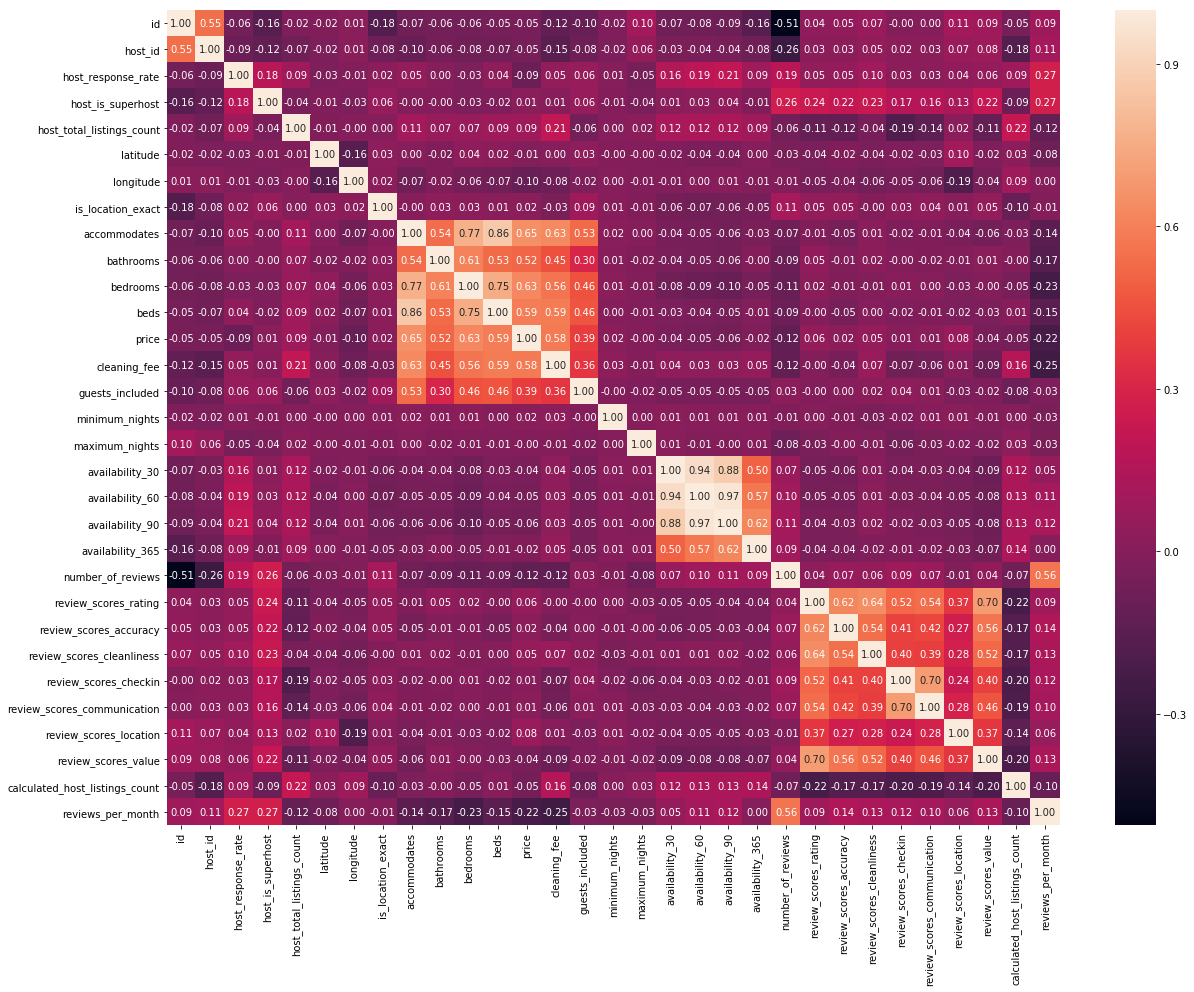

In [185]:
fig, ax = plt.pyplot.subplots(figsize=(20,15))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

In [186]:
highcorr = ['beds', 'bedrooms', 'availability_60', 'availability_90', 'availability_365']

listings.drop(highcorr, axis=1, inplace=True)

''

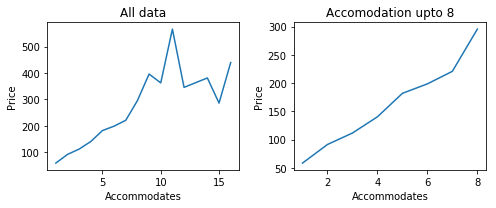

In [187]:
accom = pd.DataFrame(listings.groupby("accommodates")['price'].mean(), columns=['price'])

f,a = plt.pyplot.subplots(figsize=(7,3))
plt.pyplot.subplot(1,2,1)
plt.pyplot.title("All data")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom)

plt.pyplot.subplot(1,2,2)
plt.pyplot.title("Accomodation upto 8")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom[:8])

plt.pyplot.tight_layout()
;

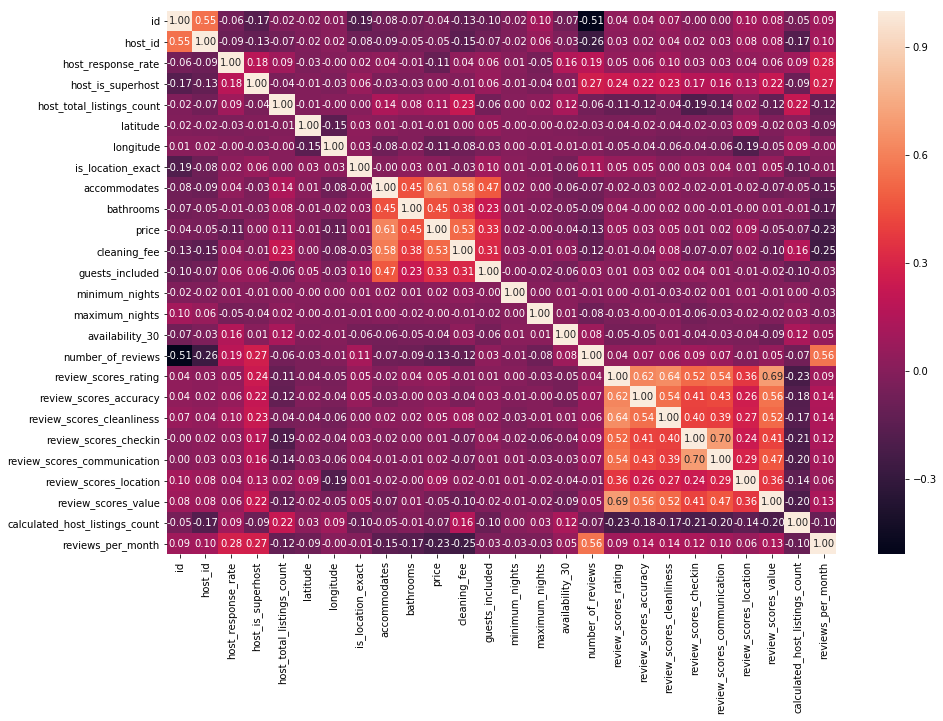

In [188]:
# Drop listings that can accommodate more than 8 people as its very noisy 
listings = listings[listings.accommodates <= 8]
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

In [189]:
# Mean listings price per neigbourhood
hood = pd.DataFrame(listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False))
hood['data_points'] = listings.neighbourhood_group_cleansed.value_counts()
hood

,price,data_points
neighbourhood_group_cleansed,,
Magnolia,166.600000,55
Downtown,152.388258,528
Queen Anne,149.314879,289
Cascade,140.101124,89
West Seattle,138.181818,198
Central Area,123.047222,360
Capitol Hill,122.230631,555
Ballard,118.964444,225
Other neighborhoods,117.512723,786


# Question 1: How to get the best price
We can see from the correlation heatmap aswell as the "accommodates vs price" chart that the main driver for price is how many people the listing can accommodate. The relationship is almost perfectly linear. Other features that are latent features of accommodation (gives more or less the same information) such as number of bedrooms, beds, bathrooms and guests included are also highly correlated. From the cell above we can also see that the average price for listings varies alot for different neighbourhoods. Magnolia, Downtown and Queen Anne are the three most expensive areas, while Northgate, University District and Delridge are the cheapest ones. Amenities such as TV, internet, washing machine and air con are also important.
There is a negative correlation to number of reviews which is probably due to some bad reviews for most listings that has been reviewed.
So the answer to the question is that you should accommodate as many people as possible in order to get the best price on AirBNB. The listings needs to be in the right area and its also important to get good reviews but not as important as to accommodate as many as possible. having a TV and a parking spot is also adviced aswell as a washer and air condition

# Question 2: How to achive better reviews?

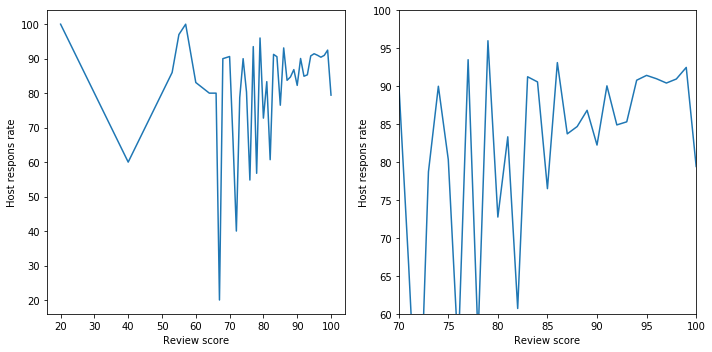

In [190]:
# visulizing the relationship between resonse rate and review score
host = pd.DataFrame(listings.groupby('review_scores_rating')['host_response_rate'].mean())
plt.pyplot.subplots(figsize=(10,5))
plt.pyplot.title("Response rate vs review score")
plt.pyplot.subplot(1,2,1)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")

# data under 70 for review score seems noisy so i made a subplot for datapoints above
plt.pyplot.subplot(1,2,2)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")
plt.pyplot.xlim(70,100)
plt.pyplot.ylim(60,100)

plt.pyplot.tight_layout()

From the correlation heatmap we can see that the most important factor for getting good reviews is to respond on all requests that guests have(host response rate), which isnt too surprising.
It also seems that hosts with many listings gets worse reviews than those who have 1 or few. One could think that having many listings could imply a worse response rate due the increased amount of inquires, but there is a very small correlation between response rate and listings count. I dont have data too support this theory, but I belive that listings by hosts with many other listings are perceived as simple and sterile with focus on maximizing economic profits while listings from people who live in the same appartment are perceived as more cozy and warm.
There is a small correlation between bathrooms, price and review score. I belive this is due to standard. Higher standard listings get better reviews. limitations on maximum nights are bad for review score and availablity is relevant.
So to get the best reviews, you should:
Not have too many listings
Respond on every inquery you get
Dont have limitations on nights to stay
include ammenities like parking space, TV and Internet
High availibility (this one you might disregard if you want to make money)

# Question 3. which time of thee year demand for rooms is more?

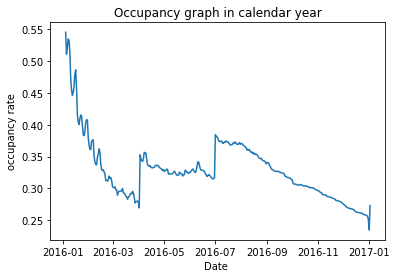

In [191]:
plt.pyplot.title("Occupancy graph in calendar year")
x=data_calendar['date']
y=data_calendar['occupancy_rate']
plt.pyplot.ylabel("occupancy rate")
plt.pyplot.xlabel("Date ")
plt.pyplot.plot(x,y,linestyle='solid')